# 导入包

In [1]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle
import function

# Source-Extractor处理和结果

## 文件路径和信息

In [2]:
CONFIG_PATH = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/"

band = "C3"
band_index = 3
band_short = "i"
band_short_capital = "I"
day = "230614"
obs_index = "10"
unkonw_index = "01"
exp_time = 600

obs_info = {"01": "20230614054340_20230614054840", "02" :"20240119021141_20240119021641", "03": "20240119021742_20240119022242", "04": "20240119022342_20240119022842", "05": "20240119022941_20240119023441"}

img_path: str = f'/home/fangwf/MCI_SimData/{day}/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L0_VER.fits'


In [3]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

print(f"reference point pixel, {x_ref}, {y_ref}")
print(f"reference point celestical, {pointing_ra}, {pointing_dec}")

reference point pixel, 4607.5, 4615.5
reference point celestical, 260.0445206737792, -0.01074148799459571


## Source-Extractor结果

### 读取已有或直接处理fits图像

In [4]:
# 读取已有结果文件
fp_out_sext = f"/home/fangwf/code/csst_mci_multiband_0614/sext_out/{band}_{band_short}_{exp_time}_out.fits"
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out_filter = Table(hdu_list[2].data)

sext_out_filter

Filename: /home/fangwf/code/csst_mci_multiband_0614/sext_out/C3_i_600_out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [12000A]   
  2  LDAC_OBJECTS    1 BinTableHDU    163   2952R x 39C   [1E, 1E, 1D, 1D, 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1E, 1I, 1E]   


X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,ALPHA_J2000,DELTA_J2000,ALPHAWIN_J2000,DELTAWIN_J2000,X_WORLD,Y_WORLD,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,THETAWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,ELLIPTICITY,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,ISOAREAF_IMAGE,FWHM_IMAGE,FLAGS,BACKGROUND
float32,float32,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,float32
3751.4717,686.86816,3754.906592186195,687.4365299802183,3617,3928,954,546,260.056409958367,-0.06530580077621627,260.05636225104104,-0.06529790719549902,260.056409958367,-0.06530580077621627,1134.3029084844177,1086.0535083111668,3.162621657925926e-06,3.0396695422180285e-06,34.419075,32.182037,0.0018003087,0.0017208079,35.552193,31.972876,0.000885168,0.0009244928,0.13589269,0.00047804238,0.00044697247,2.500427e-08,2.3900093e-08,830259400.0,23258.861,-22.298035,3.042317e-05,79952,0.0,5,15863.4
3546.1064,274.92905,3545.3526168680414,274.9678846453163,3418,3672,403,148,260.05926225424935,-0.07102717113398373,260.0592727236103,-0.07102663166251445,260.05926225424935,-0.07102717113398373,41.98838518727563,40.35617175658077,2.6409730243521707e-06,2.5729286416670562e-06,6.5416408,6.288998,0.0016406218,0.001588163,-29.883211,-33.15679,0.023843702,0.024808066,0.125265,9.085606e-05,8.734709e-05,2.2786399e-08,2.2057796e-08,41017860.0,5495.1235,-19.032433,0.00014549038,42473,56.091885,6,919.4896
7289.9907,146.23721,7290.073718271067,146.1429648859467,7246,7337,189,102,260.0072638537327,-0.07281454263734323,260.00726270249925,-0.0728158515779121,260.0072638537327,-0.07281454263734323,4.040587659155883,3.3917448217110513,2.6955399251504006e-06,2.3020555951150363e-06,2.012943,1.8385844,0.0016429732,0.0015159929,-7.4706497,-5.600932,0.24762417,0.29499483,0.031862378,2.7957512e-05,2.5535861e-05,2.2819048e-08,2.105543e-08,4215770.0,1764.4307,-16.562193,0.00045452474,4340,11.2457,7,809.96106
1208.7272,102.667206,1208.453224004334,102.54451447533039,1185,1235,123,81,260.09172585209586,-0.07341967131058968,260.0917296566075,-0.07342137536624457,260.09172585209586,-0.07341967131058968,1.4052599718592038,1.1489624083065326,2.8596063280873903e-06,2.501990684270168e-06,1.1858957,1.0713888,0.0016918607,0.0015808871,3.7207382,5.02513,0.7117356,0.8705015,0.08994907,1.647075e-05,1.4880378e-05,2.3498034e-08,2.1956733e-08,1330774.8,995.2448,-15.310262,0.0008121854,1495,22.525133,4,805.3999
5206.021,100.494896,5205.744314889308,100.33873427014927,5183,5230,121,79,260.0362078786552,-0.07344986639650489,260.03621172316855,-0.07345203531614276,260.0362078786552,-0.07344986639650489,1.3596595822981,1.0891963781767913,2.876657687121675e-06,2.494236071393056e-06,1.1684045,1.0410029,0.0017031351,0.0015716949,8.042316,13.661395,0.7362341,0.91905165,0.06041509,1.622783e-05,1.4458355e-05,2.365464e-08,2.1829068e-08,1271051.2,971.254,-15.260407,0.00082985,1362,21.839462,4,804.9758
3499.9353,20.920866,3499.850114583123,20.733093150823375,3493,3507,28,15,260.0599035209691,-0.07455505799915624,260.05990470307853,-0.07455766595741518,260.0599035209691,-0.07455505799915624,0.5755718801767579,0.4942776055037374,2.830072103782306e-05,2.6937184688716116e-05,0.7604011,0.70117015,0.0053347163,0.0051748147,10.053306,17.883883,1.7387557,2.0247304,0.043857157,1.0561119e-05,9.738463e-06,7.409322e-08,7.187235e-08,66085.4,307.97852,-12.050263,0.005061098,157,2.2225394,0,805.37695
780.2274,18.712885,780.1413250705721,18.552583209075166,775,786,24,14,260.0976772339137,-0.0745856949612777,260.09767842994023,-0.07458792136611038,260.0976772339137,-0.0745856949612777,0.5492538728833817,0.4719737707989857,6.015782050986829e-05,5.856131328836982

# Gaia参考星获取

## 读取已有或直接网络下载

In [5]:
fp_ref = "/home/fangwf/code/csst_mci_multiband_0614/sext_out/star_cat_230614.fits"
ref_filter = Table(fits.open(fp_ref)[1].data)
ref_filter

ra,dec,magu,magg,magr,magi,magz,Pos_X,Pos_Y
float64,float64,float64,float64,float64,float64,float64,float64,float64
259.98066860907585,0.0020924156379107653,19.606356,18.438757,18.037342,17.879478,17.797276,5539.5411705470015,9204.850674135349
260.04590749648196,0.004902694786529289,24.259224,21.222286,19.781658,18.728922,18.193325,5741.881188335805,4507.64876202479
260.09131614035294,-0.017718360578639993,19.031492,17.223488,16.458712,16.13401,15.951971,4113.164745976878,1238.2257936537767
260.00392589431243,0.031478372371075904,25.204172,22.166964,20.739403,19.447483,18.817167,7655.331065389298,7530.324963095564
260.07819061353075,-0.004813185742807044,29.811892,26.584747,25.08854,23.380672,22.576529,5042.337703814324,2183.2640544088326
260.0493263415502,-0.03057101663500945,26.012894,23.000996,21.576881,20.072891,19.352789,3187.773873144113,4261.491948204683
260.02016599172384,-0.0476501744887235,23.169798,20.964092,20.027906,19.633558,19.409452,1958.0738948963917,6361.036971013289
259.9908270104334,0.0156854641074244,23.051937,23.11605,23.269812,23.515541,23.67426,6518.241182182819,8473.4451589569
260.0346195923188,-0.029217255364075427,26.595865,26.617569,26.731667,26.952118,27.089188,3285.244671880198,5320.377816621687


# 三角形匹配

## Gaia参考星匹配库

In [6]:
refcat_ra_now = np.array(ref_filter["ra"])
refcat_dec_now = np.array(ref_filter["dec"])

refcat_ra_now_filter = refcat_ra_now[ref_filter["magr"] < np.percentile(ref_filter["magr"], 3)]
refcat_dec_now_filter = refcat_dec_now[ref_filter["magr"] < np.percentile(ref_filter["magr"], 3)]

ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, function.pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,260.076563,260.091316,259.980669,0.006354,-0.017718,0.002092,0.112407,0.095989,0.028234
1,260.073040,260.091316,259.980669,-0.047357,-0.017718,0.002092,0.112407,0.104774,0.034821
2,259.996086,259.980669,260.091316,-0.020731,0.002092,-0.017718,0.112407,0.095278,0.027542
3,260.056409,260.091316,259.980669,-0.065295,-0.017718,0.002092,0.112407,0.101379,0.059009
4,260.091316,260.091504,259.980669,-0.017718,0.034595,0.002092,0.115503,0.112407,0.052313
...,...,...,...,...,...,...,...,...,...
134039,260.089752,260.091311,260.019174,-0.053531,-0.055371,-0.012108,0.084116,0.081836,0.002411
134040,260.076483,260.089752,260.010741,-0.023805,-0.053531,0.000459,0.095695,0.070077,0.032553
134041,260.076483,260.091311,260.010741,-0.023805,-0.055371,0.000459,0.098022,0.070077,0.034875
134042,260.089752,260.091311,260.076483,-0.053531,-0.055371,-0.023805,0.034875,0.032553,0.002411


## 图像星匹配库

In [7]:
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = function.ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, function.pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])

sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,260.056362,260.100878,260.040773,-0.065298,-0.058423,0.044678,0.119342,0.111075,0.045043,0.0,2.0,1.0,0.0,2.0,1.0
1,260.056362,260.059273,260.040773,-0.065298,-0.071027,0.044678,0.117174,0.111075,0.006426,0.0,3.0,1.0,0.0,3.0,1.0
2,260.091484,260.040773,260.056362,0.034608,0.044678,-0.065298,0.111075,0.105900,0.051702,4.0,1.0,0.0,4.0,1.0,0.0
3,260.039030,260.056362,260.040773,-0.022376,-0.065298,0.044678,0.111075,0.067076,0.046289,5.0,0.0,1.0,5.0,0.0,1.0
4,259.996072,260.056362,260.040773,-0.020713,-0.065298,0.044678,0.111075,0.079209,0.074984,6.0,0.0,1.0,6.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,260.072364,260.071566,259.993542,-0.063499,-0.043121,-0.060955,0.080036,0.078863,0.020394,38.0,35.0,39.0,38.0,35.0,39.0
9876,260.043302,260.100171,260.072364,0.022301,0.032843,-0.063499,0.100276,0.090589,0.057838,37.0,36.0,38.0,37.0,36.0,38.0
9877,260.043302,260.100171,259.993542,0.022301,0.032843,-0.060955,0.142014,0.096993,0.057838,37.0,36.0,39.0,37.0,36.0,39.0
9878,260.072364,259.993542,260.100171,-0.063499,-0.060955,0.032843,0.142014,0.100276,0.078863,38.0,39.0,36.0,38.0,39.0,36.0


## 三角形弧长匹配

In [8]:
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])

match_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,x_1,x_2,x_3,y_1,y_2,y_3,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3
0,260.056362,260.100878,260.040773,-0.065298,-0.058423,0.044678,0.0,2.0,1.0,0.0,2.0,1.0,260.056409,260.100910,260.040804,-0.065295,-0.058434,0.044662
1,260.056362,260.059273,260.040773,-0.065298,-0.071027,0.044678,0.0,3.0,1.0,0.0,3.0,1.0,260.056409,260.059297,260.040804,-0.065295,-0.071040,0.044662
2,260.091484,260.040773,260.056362,0.034608,0.044678,-0.065298,4.0,1.0,0.0,4.0,1.0,0.0,260.091504,260.040804,260.056409,0.034595,0.044662,-0.065295
3,260.039030,260.056362,260.040773,-0.022376,-0.065298,0.044678,5.0,0.0,1.0,5.0,0.0,1.0,260.039045,260.056409,260.040804,-0.022391,-0.065295,0.044662
4,259.996072,260.056362,260.040773,-0.020713,-0.065298,0.044678,6.0,0.0,1.0,6.0,0.0,1.0,259.996086,260.056409,260.040804,-0.020731,-0.065295,0.044662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9250,260.072364,260.071566,259.993542,-0.063499,-0.043121,-0.060955,38.0,35.0,39.0,38.0,35.0,39.0,260.072379,260.071580,259.993558,-0.063518,-0.043140,-0.060973
9251,260.043302,260.100171,260.072364,0.022301,0.032843,-0.063499,37.0,36.0,38.0,37.0,36.0,38.0,260.043316,260.100186,260.072379,0.022283,0.032825,-0.063518
9252,260.043302,260.100171,259.993542,0.022301,0.032843,-0.060955,37.0,36.0,39.0,37.0,36.0,39.0,260.043316,260.100186,259.993558,0.022283,0.032825,-0.060973
9253,260.072364,259.993542,260.100171,-0.063499,-0.060955,0.032843,38.0,39.0,36.0,38.0,39.0,36.0,260.072379,259.993558,260.100186,-0.063518,-0.060973,0.032825


## 结果

In [9]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()

# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
index_num = 100
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)

# 底片模型计算

## 初步底片模型

### 计算初步底片模型

In [10]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = function.cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe
Y_eta = match_res_eta_gaia_uniqe
# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 1
A_CD_PRE = function.cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof_xy)
print(A_CD_PRE)

[[ 2.91093166e-07 -2.42404140e-07 -1.00908942e-11]
 [-3.07338400e-07  1.02386380e-12  2.42403418e-07]]


### 应用初步底片模型

In [11]:
# 应用
match_xieta = function.use_plate_model(match_x - x_ref, match_y - y_ref, A_CD_PRE, cof_xy)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[-1.02289060e+02 -5.05657328e+01 -6.14060923e+01 -1.94364267e+01
 -2.07069084e+01  8.15779777e+00  1.48925884e+01  2.49814664e+01
  1.78009787e+01  1.44619743e+01  1.10267728e+01  1.32431529e+01
  6.41613221e+00  1.13688680e+01  1.22878721e+01  7.16950487e+00
  1.04948007e+01  1.07097865e+00  1.03538885e+01  1.20072910e+01
 -2.85249037e+00  2.48402878e+00  4.86435688e+00  2.41342414e+00
  6.59735485e+00 -3.43772892e+00  2.66405552e+00  7.26062226e+00
  3.50032431e+00 -6.85172372e+00 -1.13692638e+00  7.59699401e-01
  1.08599115e+01  1.20508415e+01  1.13593825e+01  7.18068804e-02
  5.37675289e+00  1.16345361e+01  1.10518655e+01]
[-6.99141078e+01 -2.08709885e+01 -9.69275915e+00 -1.35745088e+01
 -1.70443975e+01 -6.59539962e+00  9.06965659e-01  6.16146535e+00
  6.71104050e+00  7.10123561e+00  3.43902085e+00  4.12005147e+00
  1.19919555e+01  6.93867838e+00  1.06832129e+01  1.12667915e+01
  9.66860068e+00  6.02307915e+00  5.95639693e+00  8.33761937e+00
 -2.96720048e+00  1.79890659e+00  7.5088

### 画图

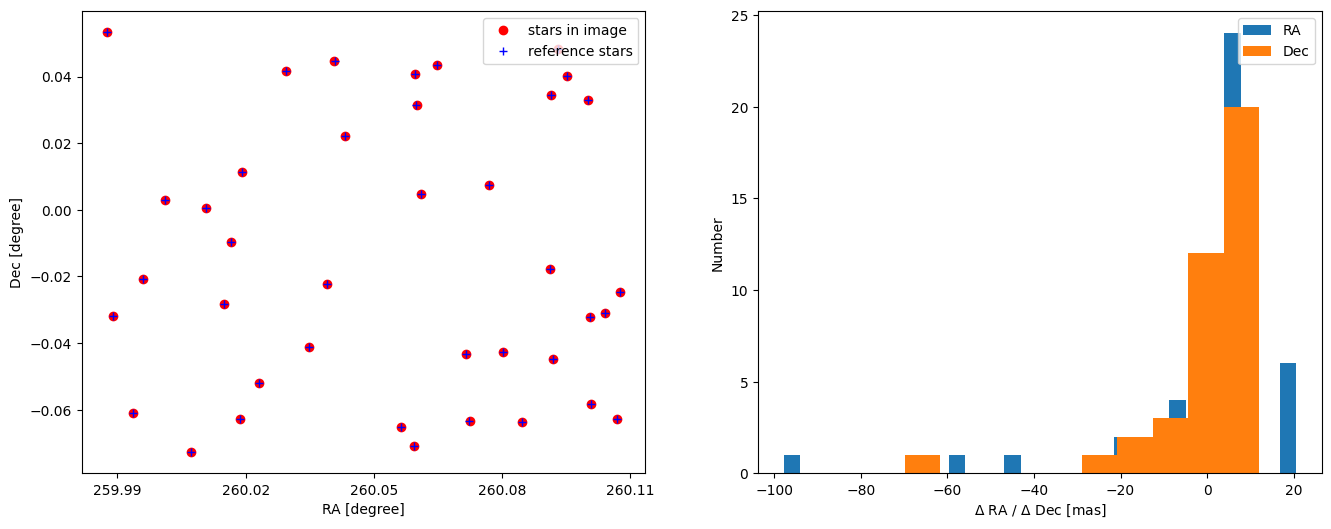

In [12]:
# fig, axes = plt.subplots(1, 1, figsize= (6, 6))
# from matplotlib.ticker import MaxNLocator

# # axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
# axes.set_ylabel("Dec [degree]")
# axes.set_xlabel("RA [degree]")
# axes.xaxis.set_major_locator(MaxNLocator(5))
# axes.legend(loc=1)
fig, axes = plt.subplots(1, 2, figsize= (16, 6))
from matplotlib.ticker import MaxNLocator
# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes[0].plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
axes[0].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
axes[0].set_ylabel("Dec [degree]")
axes[0].set_xlabel("RA [degree]")
axes[0].xaxis.set_major_locator(MaxNLocator(5))
axes[0].legend(loc=1)


axes[1].hist((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000 * np.mean(np.cos(match_res_dec_gaia_uniqe / 180 * np.pi)), label="RA", bins=10, rwidth=0.3)
axes[1].hist((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000, label="Dec", bins=10, rwidth=1)
axes[1].set_xlabel(r"$\Delta$ RA / $\Delta$ Dec [mas]")
axes[1].set_ylabel("Number")
axes[1].legend(loc=1)

## 更新底片模型

### 全体星应用初步模型

In [13]:
sext_flags = sext_out_filter[:]["FLAGS"]
sext_out_x = sext_out_filter[:]["X_IMAGE"][sext_flags == 0]
sext_out_y = sext_out_filter[:]["Y_IMAGE"][sext_flags == 0]

sext_out_xieta = function.use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD_PRE, cof_xy)
sext_out_radec = function.ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

### 全体星天球位置匹配

In [14]:
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now, "magg": ref_filter["magg"], "magr": ref_filter["magr"], "magi": ref_filter["magi"], "pos_x": ref_filter["Pos_X"], "pos_y": ref_filter["Pos_Y"]})
side_threshold = 0.00001

match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all.iloc[:, 0:2] - temp_lib) < side_threshold, axis=1) == 2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), refcat_lib_all.iloc[np.where(index == True)[0][0]])))

match_res_all = np.array(match_res_all)

### 计算更新的底片模型

In [15]:
match_res_xi_gaia_all, match_res_eta_gaia_all = function.cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all
Y_eta = match_res_eta_gaia_all

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)

for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag = match_res_all[:, band_index + 4]


print("the matched stars", len(match_x))

# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 1
cof_mag = 3

A_CD = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)
print(A_CD)

the matched stars 2260
[[-4.54472607e-06 -2.42406488e-07  1.01011408e-12  5.80844644e-07
  -2.34575730e-08  3.13522961e-10]
 [ 7.74356880e-06  4.51143041e-13  2.42407501e-07 -1.05062869e-06
   4.57579268e-08 -6.59353483e-10]]


### 再应用更新的底片模型

In [16]:
match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD, cof_xy, cof_mag)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

print(np.std(dis_ra), np.std(dis_dec), cof_xy, cof_mag)

2.465760469758665 2.423935012579888 1 3


In [17]:
# cof_mag_orders = 4
# cof_xy = 1
# for cof_mag in np.arange(1, cof_mag_orders + 1):

#     A_CD_LOOP = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)

#     match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD_LOOP, cof_xy, cof_mag)
#     match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
#     gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
#     gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)

#     # 残差
#     dis_xi = (match_xieta[0] - gaia_xieta[0])
#     dis_eta = (match_xieta[1] - gaia_xieta[1])
#     dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
#     dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "DIS_XI": dis_xi, "DIS_ETA": dis_eta, "MAG": match_mag})

with open(f'match_res/match_{band_short}_{unkonw_index}_{exp_time}_{cof_xy}_{cof_mag}.pkl', 'wb') as f:
    pickle.dump(match_res_pickle, f)

In [18]:
# cof_xy_orders = 6
# store = np.zeros((cof_xy_orders, 2))
# cof_mag = 4
# for cof_xy in np.arange(1, cof_xy_orders + 1):

#     A_CD_LOOP = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)

#     match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD_LOOP, cof_xy, cof_mag)
#     match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
#     gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
#     gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)

#     # 残差
#     dis_xi = (match_xieta[0] - gaia_xieta[0])
#     dis_eta = (match_xieta[1] - gaia_xieta[1])
#     dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
#     dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

#     print(np.std(dis_ra), np.std(dis_dec), cof_xy, cof_mag)
#     store[cof_xy - 1, 0] = np.std(dis_ra)
#     store[cof_xy - 1, 1] = np.std(dis_dec)
# store

In [19]:
# cof_mag_orders = 6
# store = np.zeros((cof_mag_orders, 2))
# cof_xy = 1
# for cof_mag in np.arange(0, cof_mag_orders + 1):

#     A_CD_LOOP = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)

#     match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD_LOOP, cof_xy, cof_mag)
#     match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
#     gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
#     gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)

#     # 残差
#     dis_xi = (match_xieta[0] - gaia_xieta[0])
#     dis_eta = (match_xieta[1] - gaia_xieta[1])
#     dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
#     dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

#     print(np.std(dis_ra), np.std(dis_dec), cof_xy, cof_mag)
#     store[cof_mag - 1, 0] = np.std(dis_ra)
#     store[cof_mag - 1, 1] = np.std(dis_dec)
# store

# 残差分析

## 残差图

### 网格化

In [20]:
# create bins
bins_num = 1
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# mag-distortion
bins_x_id, bins_y_id = function.match_box_id(match_x, match_y, bins_x, bins_y)

### 星等残差图

NameError: name 'bins_divide' is not defined

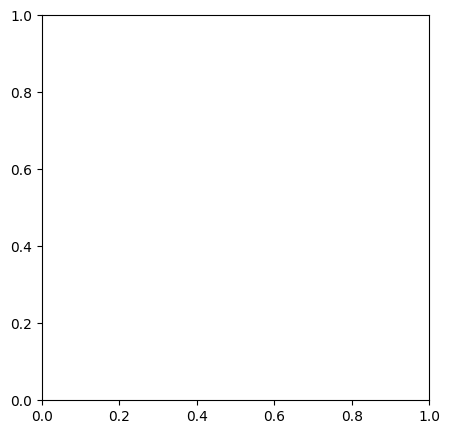

In [21]:
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        index_box = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag[index_box]
        match_x_box = match_x[index_box]
        match_y_box = match_y[index_box]
        dis_ra_box = dis_ra[index_box]
        dis_dec_box = dis_dec[index_box]

        dis_ra_box, dis_dec_box, match_mag_box, filter = function.sigma_filter_2(dis_ra_box, dis_dec_box, match_mag_box, 3)
        index_mag = (match_mag_box < 29) & (match_mag_box > 15)

        dis_ra_box = dis_ra_box[index_mag]
        dis_dec_box = dis_dec_box[index_mag]
        match_mag_box = match_mag_box[index_mag]

        bin_centers_mag_box, bins_mean_dis_ra_box, bins_std_dis_ra_box = bins_divide(match_mag_box, dis_ra_box, 8)
        bin_centers_mag_box, bins_mean_dis_dec_box, bins_std_dis_dec_box = bins_divide(match_mag_box, dis_dec_box, 8)

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_box, dis_ra_box, '.', c='blue', label="RA", alpha = 0.5)
        axe.plot(match_mag_box, dis_dec_box, '.', c='red', label="Dec", alpha = 0.5)
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_ra_box, yerr=bins_std_dis_ra_box, ecolor='blue',elinewidth=0.5,marker='s',mfc='blue',mec='blue',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="blue",label="RA errorbar")
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_dec_box, yerr=bins_std_dis_dec_box, ecolor='red',elinewidth=0.5,marker='s',mfc='red',mec='red',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="red",label="Dec errorbar")

        axe.set_xlabel(f"{band_short_capital} mag")
        axe.set_ylabel(r"$\Delta$ ra or $\Delta$ dec [mas]")

        axe.legend()

### 位置残差图

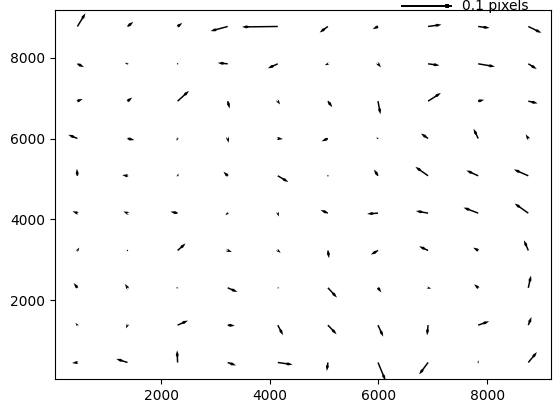

In [24]:
bins_num = 10
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
dis_res_xy = [np.vstack((match_x[filter][index_mag], match_y[filter][index_mag], dis_ra[filter][index_mag], dis_dec[filter][index_mag]))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

fig, axes = plt.subplots(1, 1)
quiver_scale = 9216
quiver_show_scale = 0.1
quiver = axes.quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten() / 50, distort_mean_values_y.flatten() / 50, scale=1 / quiver_scale, angles = 'xy', scale_units="xy", headwidth=2, headlength=3, width=0.003)
axes.quiverkey(quiver, 0.8, 1.01, quiver_show_scale, f"{quiver_show_scale} pixels",labelpos='E', coordinates='axes')